In [1]:
import pandas as pd

event_f = pd.read_csv('./archive/events.csv')
item1_f = pd.read_csv('./archive/item_properties_part1.csv')
item2_f = pd.read_csv('./archive/item_properties_part2.csv')

print(event_f.shape)
print(item1_f.shape)
print(item2_f.shape)

# 检查item中同一个itemid在不同的timestamp下对应的categoryid是否一致
items = pd.concat([item1_f, item2_f], ignore_index=True)
print('合并后 items 维度:', items.shape)

category_items = items[items['property'] == 'categoryid'][['itemid', 'value']].drop_duplicates()
# rename value to categoryid
category_items = category_items.rename(columns={'value': 'categoryid'})
print('category_items 维度:', category_items.shape)

# category_items 和 events 进行 inner join on itemid
merged = event_f.merge(category_items, on='itemid', how='inner')
print('merged 维度:', merged.shape)
print('merged 示例:')
print(merged.head(10))

(2756101, 5)
(10999999, 4)
(9275903, 4)
合并后 items 维度: (20275902, 4)
category_items 维度: (442432, 2)
merged 维度: (2709446, 6)
merged 示例:
       timestamp  visitorid event  itemid  transactionid categoryid
0  1433221332117     257597  view  355908            NaN       1173
1  1433224214164     992329  view  248676            NaN       1231
2  1433221955914     483717  view  253185            NaN        914
3  1433221337106     951259  view  367447            NaN       1613
4  1433221337106     951259  view  367447            NaN        491
5  1433224086234     972639  view   22556            NaN       1074
6  1433221923240     810725  view  443030            NaN       1098
7  1433223291897     794181  view  439202            NaN       1542
8  1433220899221     824915  view  428805            NaN        646
9  1433221204592     339335  view   82389            NaN       1404


In [2]:
import numpy as np
from datetime import datetime, timedelta

# 添加时间特征
merged['datetime'] = pd.to_datetime(merged['timestamp'], unit='ms')
merged['date'] = merged['datetime'].dt.date
merged['hour'] = merged['datetime'].dt.hour
merged['day_of_week'] = merged['datetime'].dt.dayofweek
merged['is_weekend'] = merged['day_of_week'].isin([5, 6]).astype(int)

print("添加时间特征后的数据维度:", merged.shape)
print("数据列:", merged.columns.tolist())

添加时间特征后的数据维度: (2709446, 11)
数据列: ['timestamp', 'visitorid', 'event', 'itemid', 'transactionid', 'categoryid', 'datetime', 'date', 'hour', 'day_of_week', 'is_weekend']


In [3]:
def calculate_user_behavior_features(user_events):
    """计算单个用户的行为特征"""
    features = {}
    
    # 基本统计
    event_counts = user_events['event'].value_counts()
    features['total_events'] = len(user_events)
    features['views'] = event_counts.get('view', 0)
    features['addtocarts'] = event_counts.get('addtocart', 0)
    features['transactions'] = event_counts.get('transaction', 0)
    
    # 转化率相关
    features['view_to_cart_rate'] = features['addtocarts'] / max(features['views'], 1)
    features['cart_to_purchase_rate'] = features['transactions'] / max(features['addtocarts'], 1)
    features['overall_conversion_rate'] = features['transactions'] / max(features['views'], 1)
    
    # 时间相关特征
    user_events_sorted = user_events.sort_values('timestamp')
    time_diffs = user_events_sorted['timestamp'].diff().dropna()
    
    if len(time_diffs) > 0:
        features['avg_time_between_events'] = time_diffs.mean()
        features['max_time_between_events'] = time_diffs.max()
    else:
        features['avg_time_between_events'] = 0
        features['max_time_between_events'] = 0
    
    # 会话相关特征（定义30分钟为会话间隔）
    session_threshold = 30 * 60 * 1000  # 30分钟（毫秒）
    user_events_sorted['session_flag'] = user_events_sorted['timestamp'].diff() > session_threshold
    user_events_sorted['session_id'] = user_events_sorted['session_flag'].cumsum()
    features['total_sessions'] = user_events_sorted['session_id'].nunique()
    
    # 商品多样性
    features['unique_items_viewed'] = user_events_sorted[user_events_sorted['event'] == 'view']['itemid'].nunique()
    features['unique_categories_viewed'] = user_events_sorted[user_events_sorted['event'] == 'view']['categoryid'].nunique()
    
    # 加购放弃率
    cart_events = user_events_sorted[user_events_sorted['event'] == 'addtocart']
    cart_abandonment_count = 0
    
    for _, cart_event in cart_events.iterrows():
        subsequent_events = user_events_sorted[
            (user_events_sorted['timestamp'] > cart_event['timestamp']) & 
            (user_events_sorted['itemid'] == cart_event['itemid'])
        ]
        if not any(subsequent_events['event'] == 'transaction'):
            cart_abandonment_count += 1
    
    features['cart_abandonment_rate'] = cart_abandonment_count / max(len(cart_events), 1)
    
    # 决策时间特征（从view到purchase的时间）
    purchase_decisions = []
    for _, transaction in user_events_sorted[user_events_sorted['event'] == 'transaction'].iterrows():
        # 找到同商品最近的view事件
        previous_views = user_events_sorted[
            (user_events_sorted['timestamp'] < transaction['timestamp']) & 
            (user_events_sorted['itemid'] == transaction['itemid']) & 
            (user_events_sorted['event'] == 'view')
        ]
        if len(previous_views) > 0:
            last_view = previous_views.iloc[-1]
            decision_time = transaction['timestamp'] - last_view['timestamp']
            purchase_decisions.append(decision_time)
    
    features['avg_decision_time'] = np.mean(purchase_decisions) if purchase_decisions else 0
    features['min_decision_time'] = np.min(purchase_decisions) if purchase_decisions else 0
    features['max_decision_time'] = np.max(purchase_decisions) if purchase_decisions else 0
    
    return features

In [8]:
# 计算每个用户的行为特征
print("开始计算用户行为特征...")
user_features_list = []

# 按用户分组计算特征
user_groups = merged.groupby('visitorid')
total_users = len(user_groups)

for i, (user_id, user_events) in enumerate(user_groups):
    if i % 10000 == 0:
        print(f"处理进度: {i}/{total_users} 用户")
    
    features = calculate_user_behavior_features(user_events)
    features['visitorid'] = user_id
    user_features_list.append(features)

# 转换为DataFrame
user_features_df = pd.DataFrame(user_features_list)
print("用户特征数据维度:", user_features_df.shape)
print("用户特征示例:")
print(user_features_df.head())

开始计算用户行为特征...
处理进度: 0/1236032 用户
处理进度: 10000/1236032 用户
处理进度: 20000/1236032 用户
处理进度: 30000/1236032 用户
处理进度: 40000/1236032 用户
处理进度: 50000/1236032 用户
处理进度: 60000/1236032 用户
处理进度: 70000/1236032 用户
处理进度: 80000/1236032 用户
处理进度: 90000/1236032 用户
处理进度: 100000/1236032 用户
处理进度: 110000/1236032 用户
处理进度: 120000/1236032 用户
处理进度: 130000/1236032 用户
处理进度: 140000/1236032 用户
处理进度: 150000/1236032 用户
处理进度: 160000/1236032 用户
处理进度: 170000/1236032 用户
处理进度: 180000/1236032 用户
处理进度: 190000/1236032 用户
处理进度: 200000/1236032 用户
处理进度: 210000/1236032 用户
处理进度: 220000/1236032 用户
处理进度: 230000/1236032 用户
处理进度: 240000/1236032 用户
处理进度: 250000/1236032 用户
处理进度: 260000/1236032 用户
处理进度: 270000/1236032 用户
处理进度: 280000/1236032 用户
处理进度: 290000/1236032 用户
处理进度: 300000/1236032 用户
处理进度: 310000/1236032 用户
处理进度: 320000/1236032 用户
处理进度: 330000/1236032 用户
处理进度: 340000/1236032 用户
处理进度: 350000/1236032 用户
处理进度: 360000/1236032 用户
处理进度: 370000/1236032 用户
处理进度: 380000/1236032 用户
处理进度: 390000/1236032 用户
处理进度: 400000/1236032 用户
处理进度: 410000/123

In [4]:
user_features_df = pd.read_csv('./user_features_detailed.csv')

=== Analyzing Buyer Behavior Only ===
有购买行为的用户数量: 11569
购买事件数量: 23369
涉及商品数量: 11645
涉及类别数量: 751


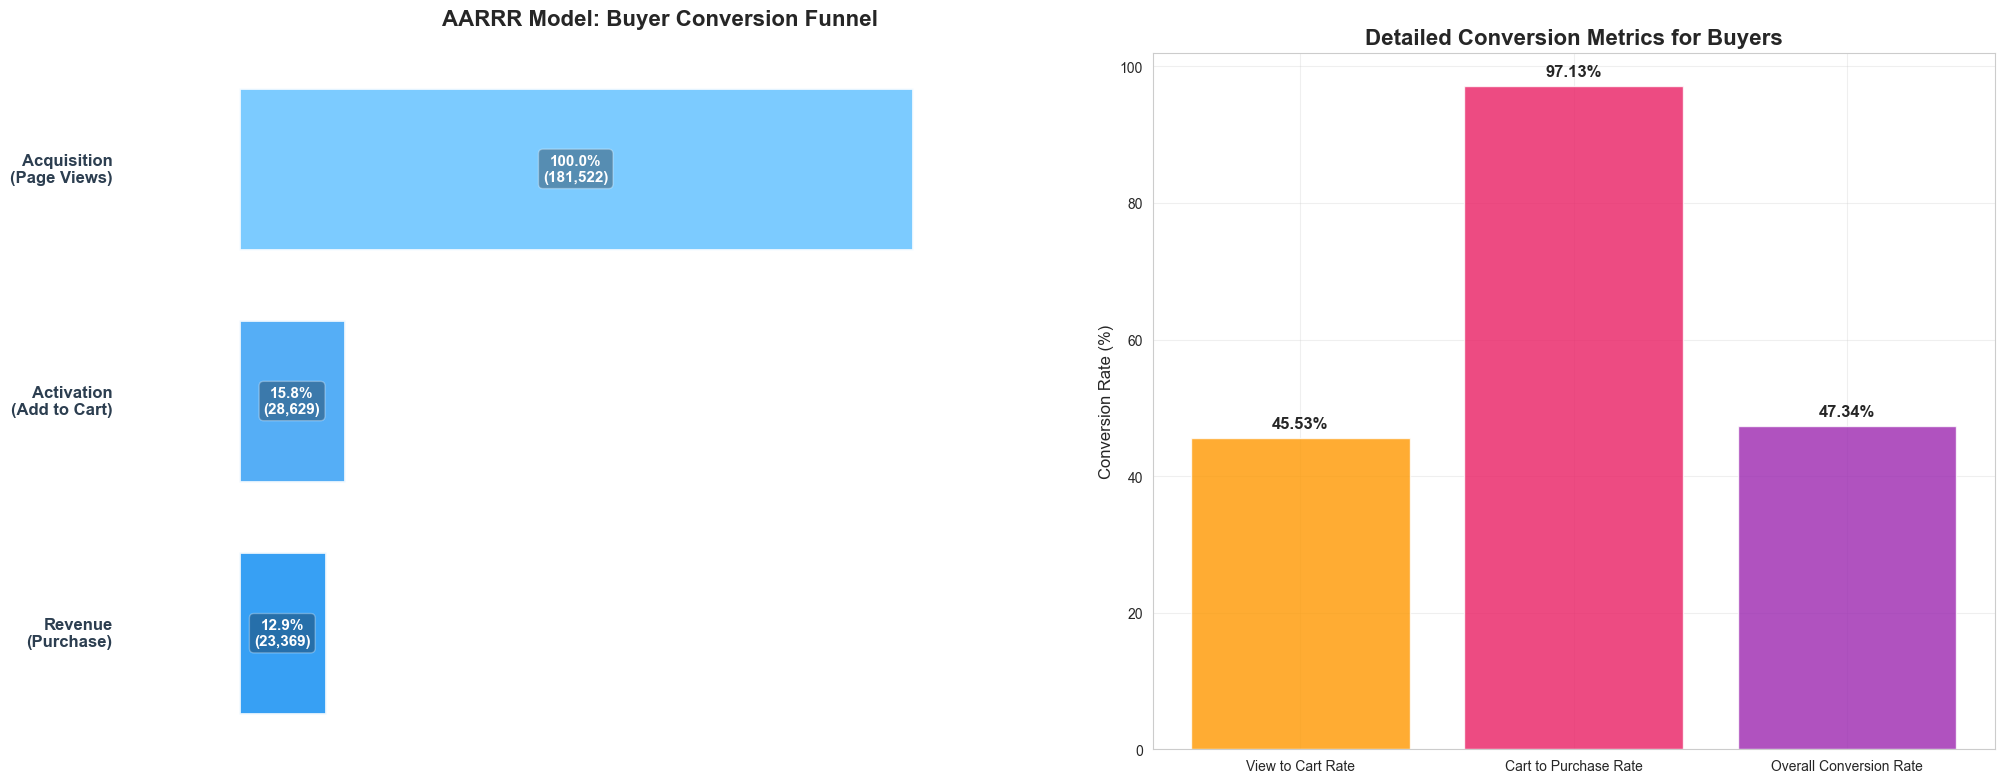

/var/folders/wj/6r68fbps69s8g9jhn28514n00000gn/T/ipykernel_10628/1175130938.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchase_times['hour'] = purchase_times['datetime'].dt.hour
/var/folders/wj/6r68fbps69s8g9jhn28514n00000gn/T/ipykernel_10628/1175130938.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchase_times['day_of_week'] = purchase_times['datetime'].dt.dayofweek


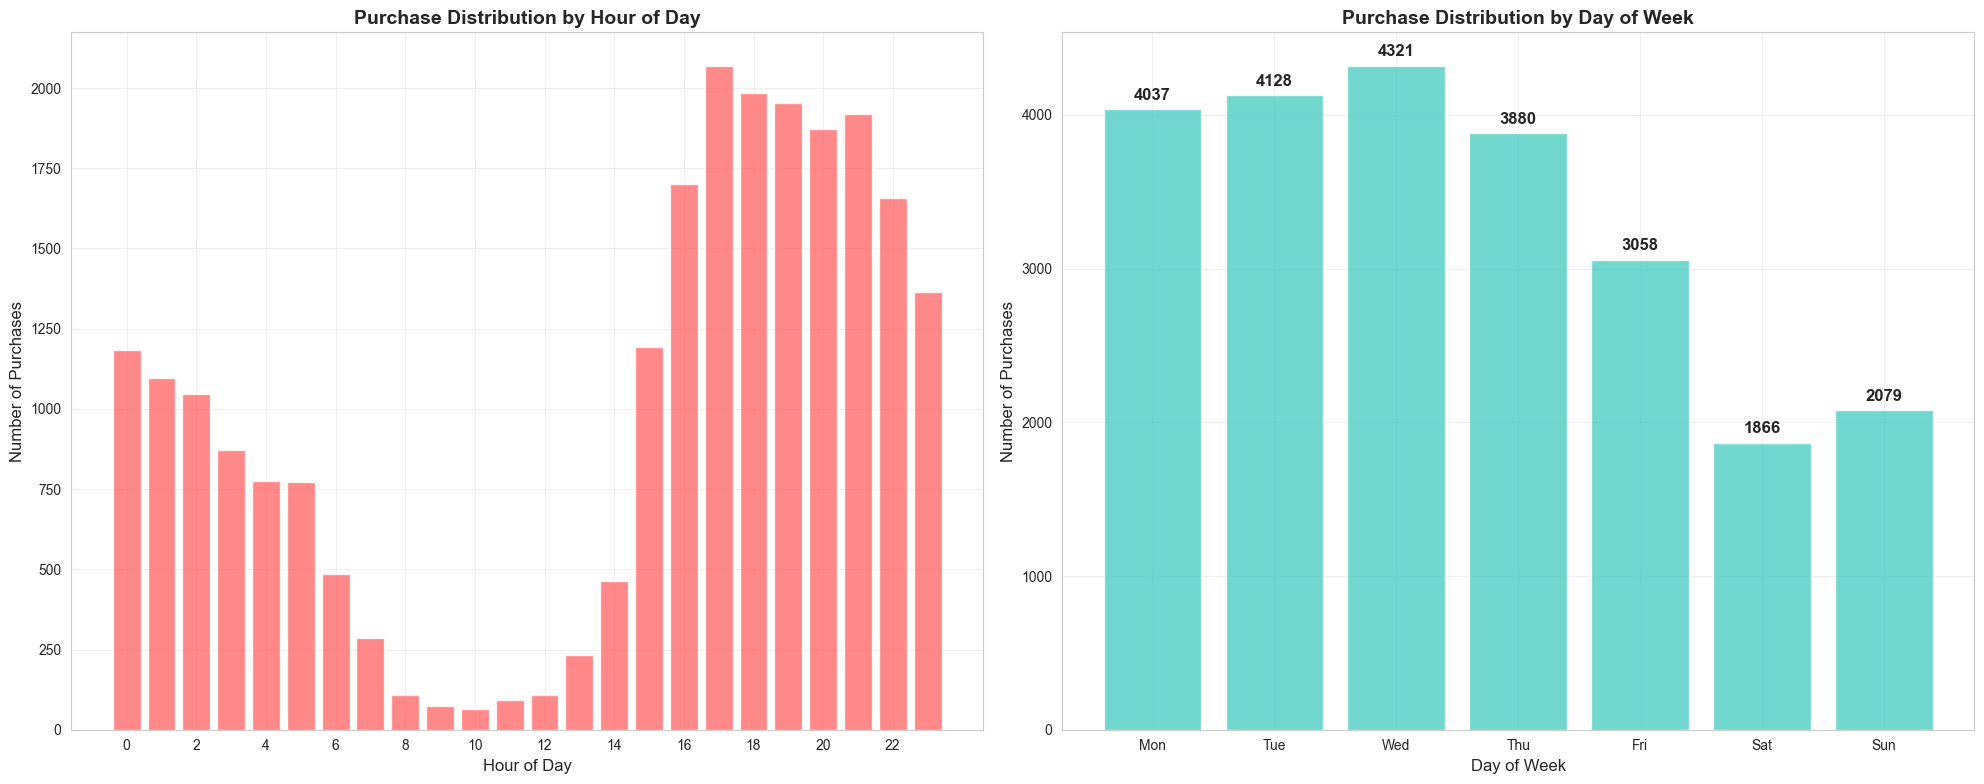

/var/folders/wj/6r68fbps69s8g9jhn28514n00000gn/T/ipykernel_10628/1175130938.py:198: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax2.boxplot(boxplot_data, labels=metric_names, patch_artist=True,


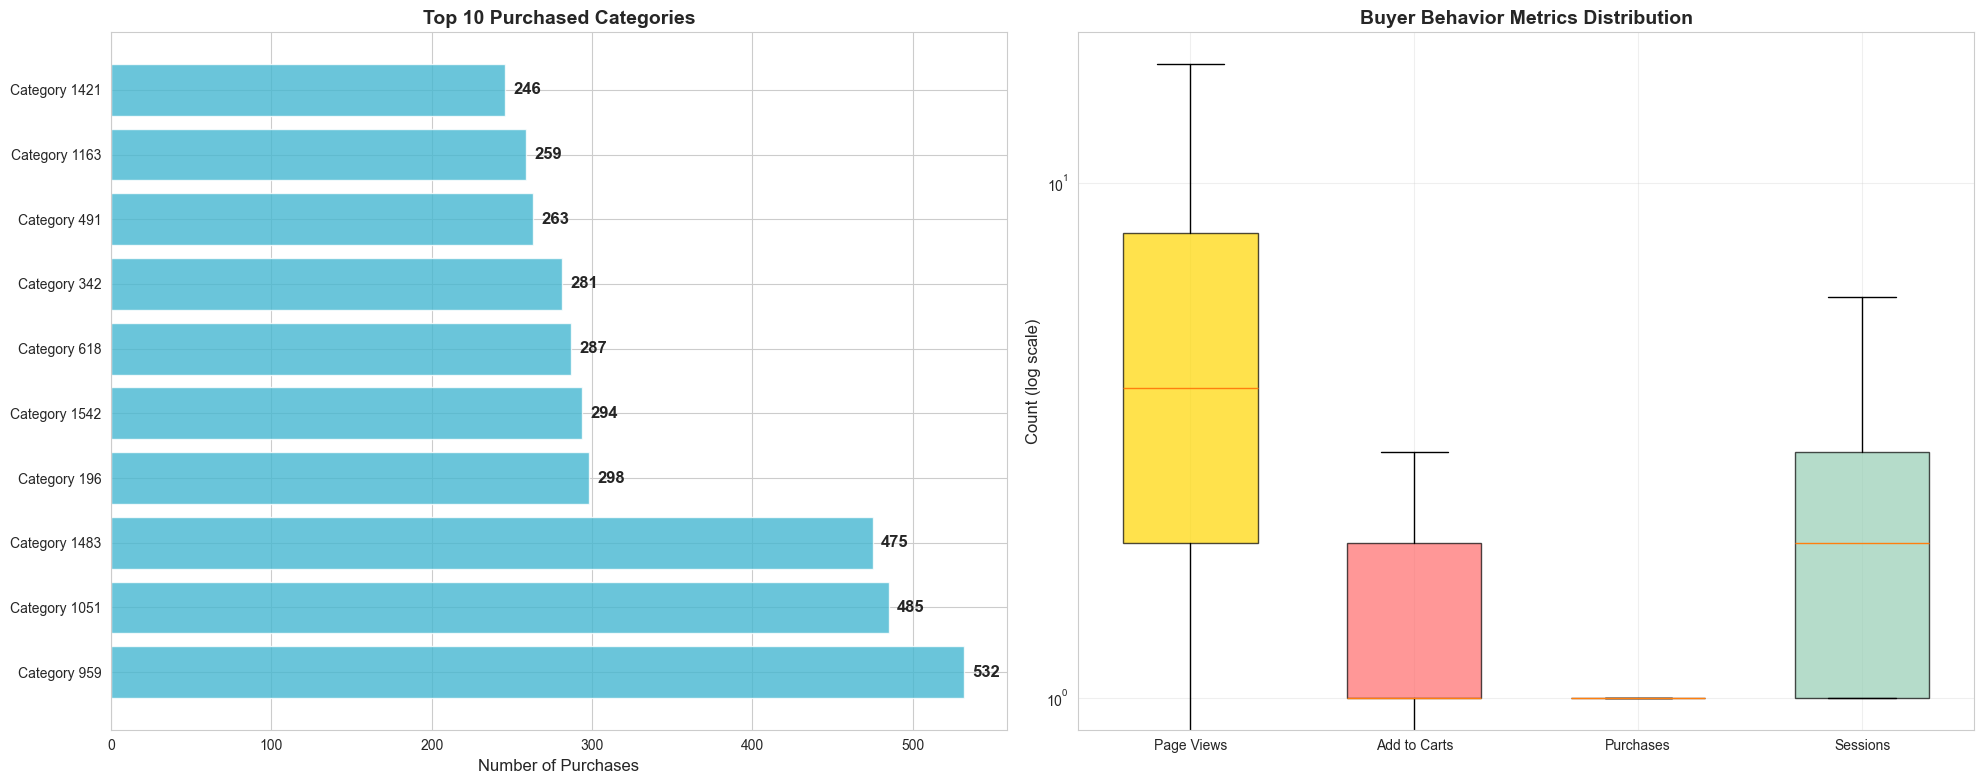

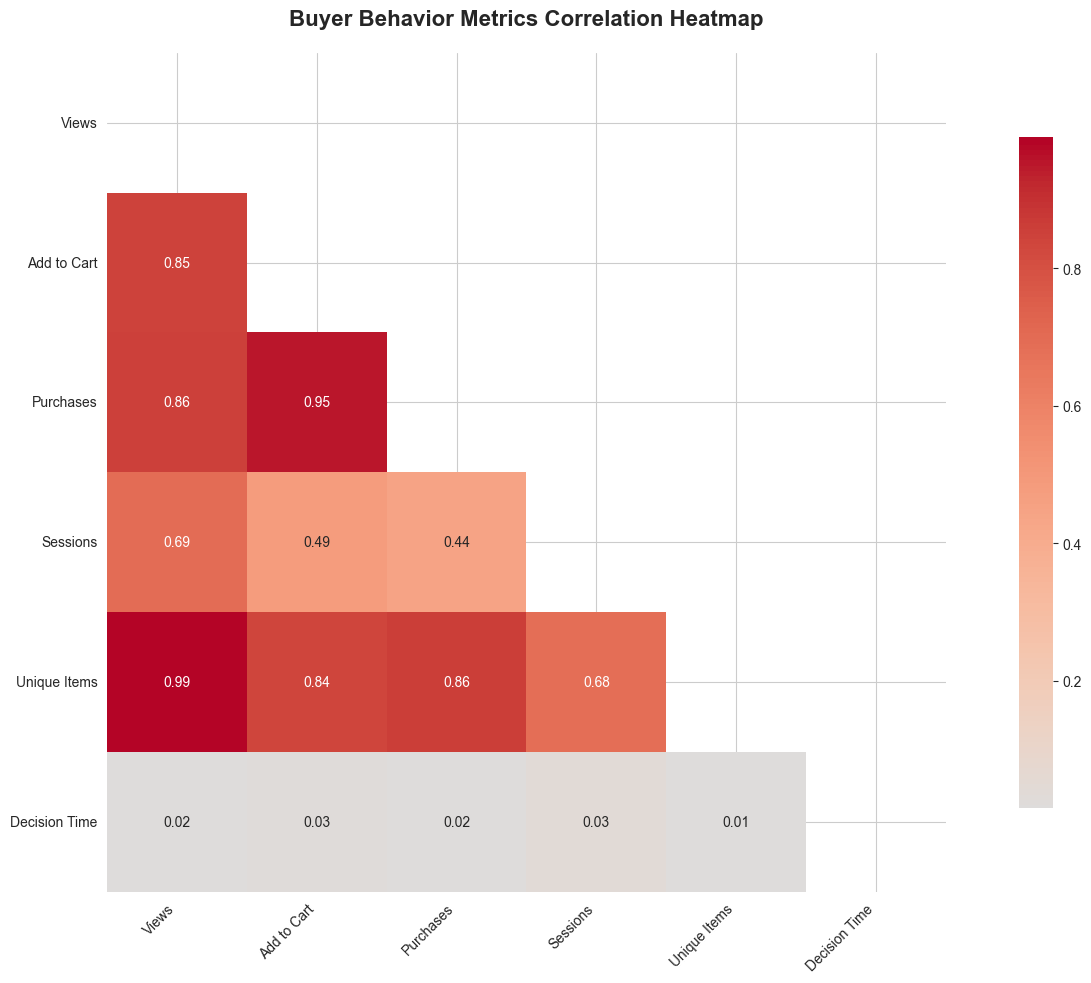

=== Buyer Analysis Complete ===
Generated Charts:
1. buyer_aarrr_funnel.png - AARRR转化漏斗和转化率详情
2. buyer_purchase_timing.png - 购买时间分布（小时和星期）
3. buyer_category_behavior.png - 热门类别和购买行为分布
4. buyer_correlation_heatmap.png - 购买者行为指标相关性分析

=== Key Buyer Insights ===
平均每个购买者:
- 浏览次数: 15.7
- 加购次数: 2.5
- 购买次数: 2.0
- 会话次数: 3.6
- 平均决策时间: 120.8 分钟
- 总体转化率: 47.34%


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime

# 设置专业图表样式
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})
sns.set_style("whitegrid")

print("=== Analyzing Buyer Behavior Only ===")

# 筛选有购买行为的用户
buyers_df = user_features_df[user_features_df['transactions'] > 0].copy()
print(f"有购买行为的用户数量: {len(buyers_df)}")

# 关联商品类别信息（使用之前处理好的merged数据）
# 获取购买事件
purchase_events = merged[merged['event'] == 'transaction']
buyer_purchases = purchase_events[purchase_events['visitorid'].isin(buyers_df['visitorid'])]

print(f"购买事件数量: {len(buyer_purchases)}")
print(f"涉及商品数量: {buyer_purchases['itemid'].nunique()}")
print(f"涉及类别数量: {buyer_purchases['categoryid'].nunique()}")

# 1. 创建AARRR模型的购买者转化漏斗
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# 图表1: AARRR风格漏斗图
aarrr_stages = [
    'Acquisition\n(Page Views)',
    'Activation\n(Add to Cart)', 
    'Revenue\n(Purchase)'
]

# 计算购买者的转化数据
buyer_funnel_data = {
    'Stage': aarrr_stages,
    'Count': [
        buyers_df['views'].sum(),
        buyers_df['addtocarts'].sum(),
        buyers_df['transactions'].sum()
    ]
}

buyer_funnel_df = pd.DataFrame(buyer_funnel_data)
buyer_funnel_df['Percentage'] = [
    100,
    (buyer_funnel_df.loc[1, 'Count'] / buyer_funnel_df.loc[0, 'Count']) * 100,
    (buyer_funnel_df.loc[2, 'Count'] / buyer_funnel_df.loc[0, 'Count']) * 100
]

# AARRR颜色方案
aarrr_colors = ['#6EC6FF', '#42A5F5', '#2196F3', '#1976D2', '#0D47A1'][:3]

# 创建漏斗图
y_positions = range(len(aarrr_stages), 0, -1)
widths = [width * 0.8 for width in buyer_funnel_df['Percentage'] / 100]

for i, (stage, y_pos, width, color) in enumerate(zip(aarrr_stages, y_positions, widths, aarrr_colors)):
    ax1.barh(y_pos, width, height=0.7, color=color, alpha=0.9, edgecolor='white', linewidth=2)
    
    # 添加阶段标签
    ax1.text(-0.15, y_pos, stage, ha='right', va='center', fontweight='bold', 
             fontsize=12, color='#2C3E50')
    
    # 添加数据标签
    percent = buyer_funnel_df.loc[i, 'Percentage']
    count = buyer_funnel_df.loc[i, 'Count']
    ax1.text(width/2, y_pos, f'{percent:.1f}%\n({count:,})', 
             ha='center', va='center', color='white', fontweight='bold', fontsize=11,
             bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.3))

ax1.set_xlim(0, 1)
ax1.set_ylim(0.5, len(aarrr_stages) + 0.5)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('AARRR Model: Buyer Conversion Funnel', fontsize=16, fontweight='bold', pad=20)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

# 图表2: 转化率细节条形图
conversion_metrics = [
    'View to Cart Rate',
    'Cart to Purchase Rate', 
    'Overall Conversion Rate'
]

conversion_values = [
    buyers_df['view_to_cart_rate'].mean() * 100,
    buyers_df['cart_to_purchase_rate'].mean() * 100,
    buyers_df['overall_conversion_rate'].mean() * 100
]

bars = ax2.bar(conversion_metrics, conversion_values, 
               color=['#FF9800', '#E91E63', '#9C27B0'], alpha=0.8)

ax2.set_ylabel('Conversion Rate (%)')
ax2.set_title('Detailed Conversion Metrics for Buyers', fontsize=16, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 在柱子上添加数值
for bar, value in zip(bars, conversion_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{value:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('buyer_aarrr_funnel.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. 购买时间分析
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# 图表3: 购买时间分布（按小时）
# 从原始事件数据中提取购买时间
buyer_events = merged[merged['visitorid'].isin(buyers_df['visitorid'])]
purchase_times = buyer_events[buyer_events['event'] == 'transaction']

if len(purchase_times) > 0:
    purchase_times['hour'] = purchase_times['datetime'].dt.hour
    hourly_purchases = purchase_times['hour'].value_counts().sort_index()
    
    hours = range(24)
    purchase_counts = [hourly_purchases.get(hour, 0) for hour in hours]
    
    ax1.bar(hours, purchase_counts, color='#FF6B6B', alpha=0.8, edgecolor='white')
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Number of Purchases')
    ax1.set_title('Purchase Distribution by Hour of Day', fontsize=14, fontweight='bold')
    ax1.set_xticks(range(0, 24, 2))
    ax1.grid(True, alpha=0.3)

# 图表4: 购买时间分布（按星期）
purchase_times['day_of_week'] = purchase_times['datetime'].dt.dayofweek
daily_purchases = purchase_times['day_of_week'].value_counts().sort_index()

days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
purchase_counts_daily = [daily_purchases.get(i, 0) for i in range(7)]

ax2.bar(days, purchase_counts_daily, color='#4ECDC4', alpha=0.8, edgecolor='white')
ax2.set_xlabel('Day of Week')
ax2.set_ylabel('Number of Purchases')
ax2.set_title('Purchase Distribution by Day of Week', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 添加数值标签
for i, count in enumerate(purchase_counts_daily):
    ax2.text(i, count + max(purchase_counts_daily)*0.01, f'{count}', 
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('buyer_purchase_timing.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. 商品类别分析
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# 图表5: 热门购买类别
if len(buyer_purchases) > 0:
    # 获取购买最多的类别
    top_categories = buyer_purchases['categoryid'].value_counts().head(10)
    
    # 创建水平条形图
    y_pos = range(len(top_categories))
    ax1.barh(y_pos, top_categories.values, color='#45B7D1', alpha=0.8)
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels([f'Category {cat}' for cat in top_categories.index])
    ax1.set_xlabel('Number of Purchases')
    ax1.set_title('Top 10 Purchased Categories', fontsize=14, fontweight='bold')
    
    # 添加数值标签
    for i, count in enumerate(top_categories.values):
        ax1.text(count + max(top_categories.values)*0.01, i, f'{count}', 
                 va='center', ha='left', fontweight='bold')

# 图表6: 购买者行为指标分布
behavior_metrics = ['views', 'addtocarts', 'transactions', 'total_sessions']
metric_names = ['Page Views', 'Add to Carts', 'Purchases', 'Sessions']

# 由于数据尺度差异大，使用对数尺度
boxplot_data = []
for metric in behavior_metrics:
    # 过滤极端值
    data = buyers_df[metric]
    q95 = data.quantile(0.95)
    filtered_data = data[data <= q95]
    boxplot_data.append(filtered_data)

box_plot = ax2.boxplot(boxplot_data, labels=metric_names, patch_artist=True, 
                      showfliers=False, widths=0.6)

# 设置颜色
colors = ['#FFD700', '#FF6B6B', '#4ECDC4', '#96CEB4']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_ylabel('Count (log scale)')
ax2.set_yscale('log')
ax2.set_title('Buyer Behavior Metrics Distribution', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('buyer_category_behavior.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. 购买者特征综合分析
plt.figure(figsize=(15, 10))

# 选择关键指标进行相关性分析
key_metrics = ['views', 'addtocarts', 'transactions', 'total_sessions', 
               'unique_items_viewed', 'avg_decision_time']

# 计算相关性矩阵
correlation_matrix = buyers_df[key_metrics].corr()

# 创建美观的热图
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
heatmap = sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm',
                      center=0, square=True, fmt='.2f', cbar_kws={"shrink": .8},
                      annot_kws={"size": 10})

# 美化标签
metric_labels = ['Views', 'Add to Cart', 'Purchases', 'Sessions', 'Unique Items', 'Decision Time']
heatmap.set_xticklabels(metric_labels, rotation=45, ha='right')
heatmap.set_yticklabels(metric_labels, rotation=0)

plt.title('Buyer Behavior Metrics Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('buyer_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("=== Buyer Analysis Complete ===")
print("Generated Charts:")
print("1. buyer_aarrr_funnel.png - AARRR转化漏斗和转化率详情")
print("2. buyer_purchase_timing.png - 购买时间分布（小时和星期）")
print("3. buyer_category_behavior.png - 热门类别和购买行为分布")
print("4. buyer_correlation_heatmap.png - 购买者行为指标相关性分析")

# 输出关键统计信息
print("\n=== Key Buyer Insights ===")
print(f"平均每个购买者:")
print(f"- 浏览次数: {buyers_df['views'].mean():.1f}")
print(f"- 加购次数: {buyers_df['addtocarts'].mean():.1f}")
print(f"- 购买次数: {buyers_df['transactions'].mean():.1f}")
print(f"- 会话次数: {buyers_df['total_sessions'].mean():.1f}")
print(f"- 平均决策时间: {buyers_df['avg_decision_time'].mean()/(60 * 1000):.1f} 分钟")
print(f"- 总体转化率: {buyers_df['overall_conversion_rate'].mean()*100:.2f}%")

=== Creating Optimized Layout Charts ===


/var/folders/wj/6r68fbps69s8g9jhn28514n00000gn/T/ipykernel_10628/2672022249.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchase_times['hour'] = purchase_times['datetime'].dt.hour
/var/folders/wj/6r68fbps69s8g9jhn28514n00000gn/T/ipykernel_10628/2672022249.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchase_times['day_of_week'] = purchase_times['datetime'].dt.dayofweek


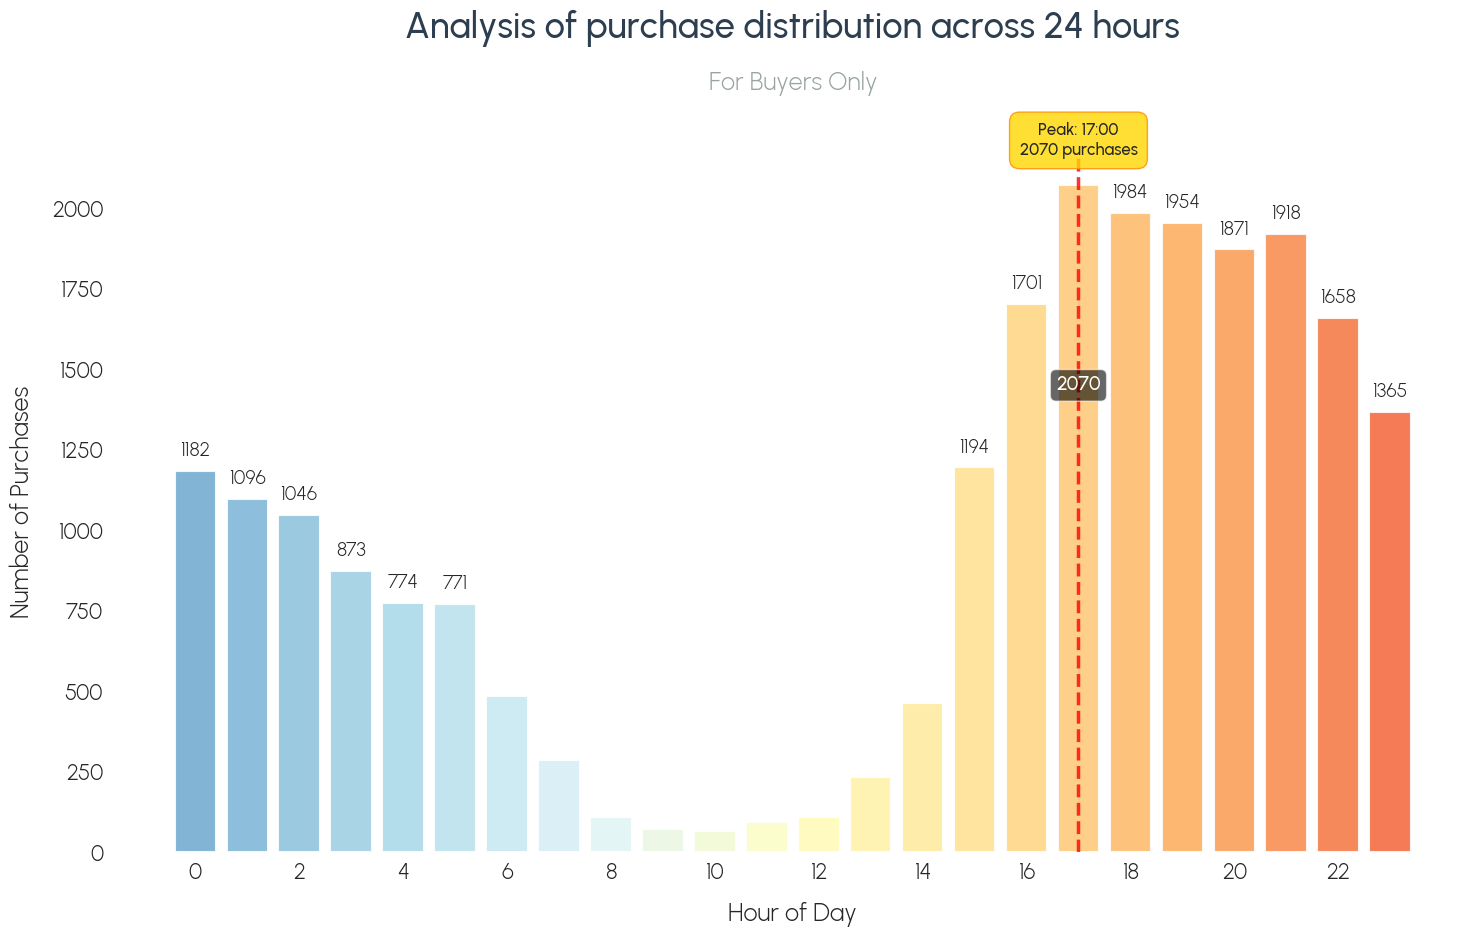

✓ Hourly distribution chart with optimized layout saved


/var/folders/wj/6r68fbps69s8g9jhn28514n00000gn/T/ipykernel_10628/2672022249.py:139: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([d[:3] for d in days], fontproperties=font, fontsize=16)
/var/folders/wj/6r68fbps69s8g9jhn28514n00000gn/T/ipykernel_10628/2672022249.py:143: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(ax2.get_yticks(), fontproperties=font)


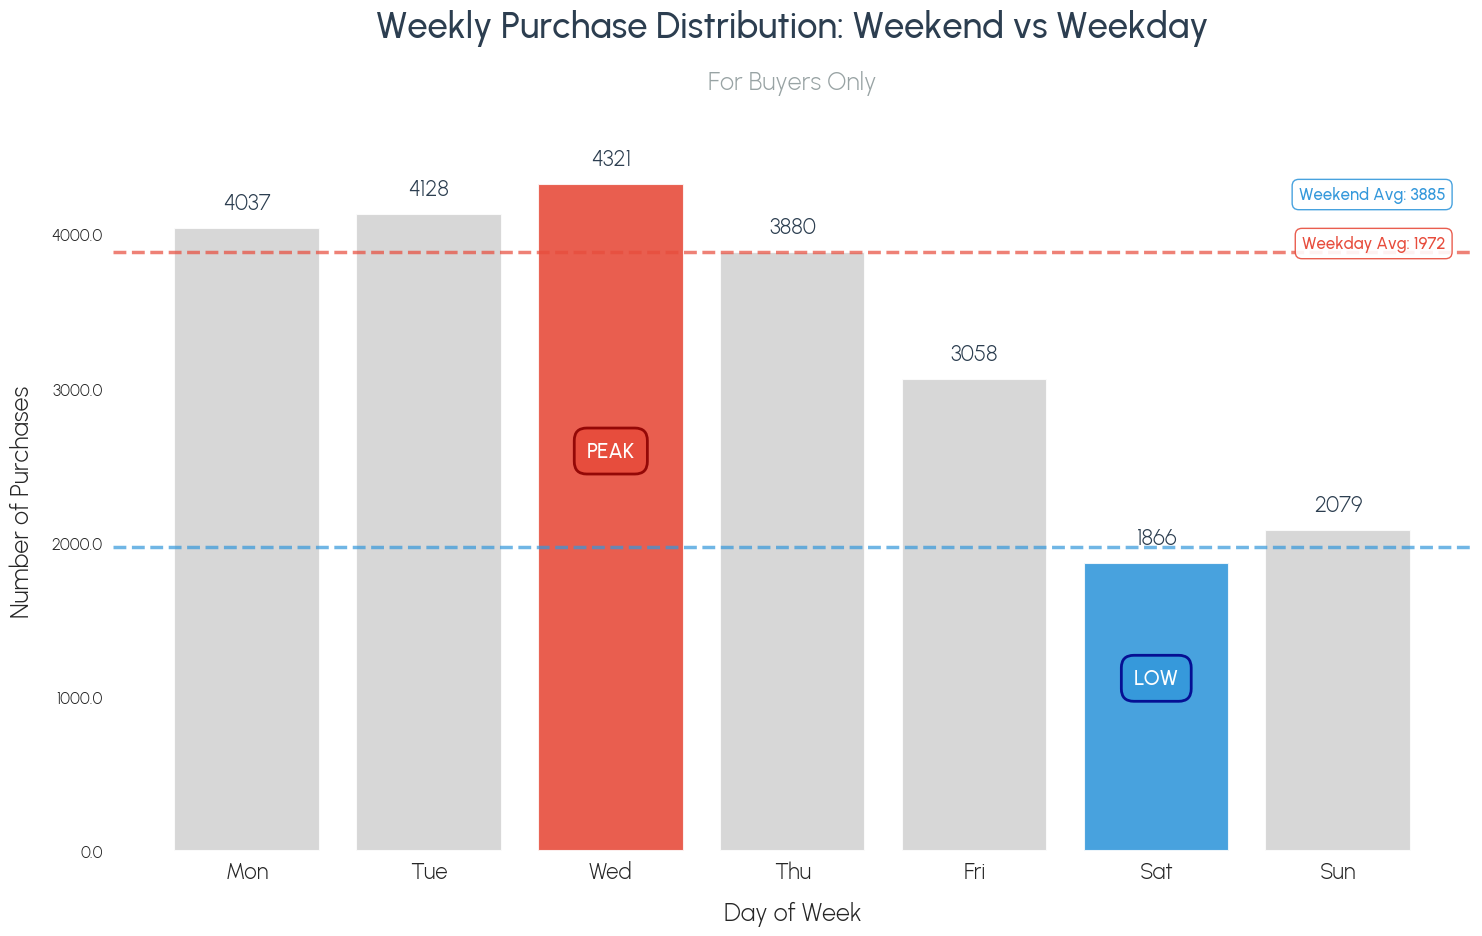

✓ Weekly distribution chart with optimized layout saved
=== Optimized Chart Generation Complete ===
Generated files:
1. hourly_distribution_optimized.png - 优化布局的小时分布图
2. weekly_distribution_optimized.png - 优化布局的星期分布图


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from pyfonts import load_google_font

# 加载Urbanist字体
font = load_google_font("Urbanist", weight="light")
bold_font = load_google_font("Urbanist", weight="medium")

# 设置专业简洁的样式
plt.rcParams.update({
    'font.size': 16,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.bottom': False,
    'axes.spines.left': False,
    'axes.grid': False,
    'xtick.bottom': False,
    'ytick.left': False
})

print("=== Creating Optimized Layout Charts ===")

# 从数据中提取购买时间信息
buyer_events = merged[merged['visitorid'].isin(buyers_df['visitorid'])]
purchase_times = buyer_events[buyer_events['event'] == 'transaction']

if len(purchase_times) > 0:
    # 提取时间特征
    purchase_times['hour'] = purchase_times['datetime'].dt.hour
    purchase_times['day_of_week'] = purchase_times['datetime'].dt.dayofweek
    
    # ============================================
    # 图表1: 小时分布图 - 优化布局，标题更大
    # ============================================
    fig1, ax1 = plt.subplots(figsize=(16, 10))
    
    # 调整子图位置，为标题留出更多空间
    fig1.subplots_adjust(top=0.85, bottom=0.15, left=0.1, right=0.95)
    
    hourly_purchases = purchase_times['hour'].value_counts().sort_index()
    hours = range(24)
    purchase_counts = [hourly_purchases.get(hour, 0) for hour in hours]
    
    max_count = max(purchase_counts)
    max_hour = purchase_counts.index(max_count)
    
    # 使用渐变色
    colors = plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, 24))
    bars = ax1.bar(hours, purchase_counts, color=colors, alpha=0.9, 
                   edgecolor='white', linewidth=1.5)
    
    # 设置坐标轴标签
    ax1.set_xlabel('Hour of Day', font=font, size=18, labelpad=12)
    ax1.set_ylabel('Number of Purchases', font=font, size=18, labelpad=12)
    ax1.set_xticks(range(0, 24, 2))
    ax1.set_yticks(range(0, 2250, 250))
    ytick_labels = [f'{number}' for number in range(0, 2250, 250)]
    xtick_labels = [f'{hour}' for hour in range(0, 24, 2)]
    ax1.set_xticklabels(xtick_labels, fontproperties=font, fontsize=16)  # 增大到16号字体
    ax1.set_yticklabels(ytick_labels, fontproperties=font, fontsize=16)  # 增大到16号字体
    
    # 更大的标题 - 居中显示
    ax1.text(0.5, 1.15, 'Analysis of purchase distribution across 24 hours', 
             transform=ax1.transAxes, font=bold_font, size=26, 
             ha='center', va='bottom', color='#2C3E50')
    
    # 副标题
    ax1.text(0.5, 1.08, 'For Buyers Only', 
             transform=ax1.transAxes, font=font, size=18, color='#7F8C8D', alpha=0.8,
             ha='center', va='bottom')
    
    # 突出显示峰值小时
    ax1.axvline(x=max_hour, color='red', linestyle='--', alpha=0.8, linewidth=2.5)
    
    # 峰值标注
    peak_y_position = max_count * 1.04
    ax1.text(max_hour, peak_y_position, f'Peak: {max_hour}:00\n{max_count} purchases', 
             ha='center', va='bottom', font=bold_font, size=12,
             bbox=dict(boxstyle='round,pad=0.6', facecolor='gold', alpha=0.8,
                      edgecolor='darkorange', linewidth=1))
    
    # 添加数值标签
    for hour, count in enumerate(purchase_counts):
        if count > max_count * 0.3:
            if hour == max_hour:
                # 峰值柱子的标签放在内部
                label_y = count * 0.7
                ax1.text(hour, label_y, f'{count}', 
                        ha='center', va='center', font=bold_font, size=14,
                        color='white', 
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.6))
            else:
                # 其他柱子标签放在顶部
                label_y = count + max_count * 0.015
                ax1.text(hour, label_y, f'{count}', 
                        ha='center', va='bottom', font=font, size=14)
    
    plt.savefig('hourly_distribution_optimized.png', dpi=500, bbox_inches='tight')
    plt.savefig('hourly_distribution_optimized.pdf')
    plt.show()
    
    print("✓ Hourly distribution chart with optimized layout saved")
    
    # ============================================
    # 图表2: 星期分布图 - 优化布局
    # ============================================
    fig2, ax2 = plt.subplots(figsize=(16, 10))
    
    # 调整子图位置
    fig2.subplots_adjust(top=0.85, bottom=0.15, left=0.1, right=0.95)
    
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily_purchases = purchase_times['day_of_week'].value_counts().sort_index()
    daily_counts = [daily_purchases.get(i, 0) for i in range(7)]
    
    # 找到最高和最低购买日
    max_day_idx = np.argmax(daily_counts)
    min_day_idx = np.argmin(daily_counts)
    max_daily_count = max(daily_counts)
    
    # 计算平均值
    weekday_avg = np.mean(daily_counts[:5])
    weekend_avg = np.mean(daily_counts[5:])
    
    # 只让最高和最低有颜色
    day_colors = ['lightgray'] * 7
    day_colors[max_day_idx] = '#E74C3C'  # 最高购买日 - 红色
    day_colors[min_day_idx] = '#3498DB'   # 最低购买日 - 蓝色
    
    bars2 = ax2.bar([d[:3] for d in days], daily_counts, color=day_colors, alpha=0.9,
                   edgecolor='white', linewidth=1.5)
    
    # 设置坐标轴标签
    ax2.set_xlabel('Day of Week', font=font, size=18, labelpad=12)
    ax2.set_ylabel('Number of Purchases', font=font, size=18, labelpad=12)
    # 设置X轴刻度标签（星期几）的字体和大小
    ax2.set_xticklabels([d[:3] for d in days], fontproperties=font, fontsize=16)

    # 设置Y轴刻度标签的字体和大小
    ax2.tick_params(axis='y', labelsize=16)
    ax2.set_yticklabels(ax2.get_yticks(), fontproperties=font)
    
    # 更大的标题 - 居中显示
    ax2.text(0.5, 1.15, 'Weekly Purchase Distribution: Weekend vs Weekday', 
             transform=ax2.transAxes, font=bold_font, size=26, 
             ha='center', va='bottom', color='#2C3E50')
    
    # 副标题
    ax2.text(0.5, 1.08, 'For Buyers Only', 
             transform=ax2.transAxes, font=font, size=18, color='#7F8C8D', alpha=0.8,
             ha='center', va='bottom')
    
    # 添加平均值线
    ax2.axhline(y=weekend_avg, color='#3498DB', linestyle='--', alpha=0.7, 
                linewidth=2.5)
    ax2.axhline(y=weekday_avg, color='#E74C3C', linestyle='--', alpha=0.7, 
                linewidth=2.5)
    
    # 添加数值标签
    for i, count in enumerate(daily_counts):
        label_y = count + max_daily_count * 0.02
        ax2.text(i, label_y, f'{count}', 
                ha='center', va='bottom', font=font, size=16, color='#2C3E50')
    
    # 图例放在右边
    ax2.text(0.98, 0.95, f'Weekend Avg: {weekday_avg:.0f}', 
             transform=ax2.transAxes, font=bold_font, size=12, color='#3498DB',
             ha='right', va='top',
             bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.9,
                      edgecolor='#3498DB', linewidth=1))
    
    ax2.text(0.98, 0.88, f'Weekday Avg: {weekend_avg:.0f}', 
             transform=ax2.transAxes, font=bold_font, size=12, color='#E74C3C',
             ha='right', va='top',
             bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.9,
                      edgecolor='#E74C3C', linewidth=1))
    
    # 为最高和最低购买日添加标注
    ax2.text(max_day_idx, daily_counts[max_day_idx] * 0.6, 'PEAK', 
         ha='center', va='center', font=bold_font, size=15, 
         color='white', rotation=0, fontweight='extra bold',  # 使用extra bold
         bbox=dict(boxstyle='round,pad=0.6', facecolor='#E74C3C', alpha=0.9,
                  edgecolor='#8B0000', linewidth=2))         # 更粗的边框

    ax2.text(min_day_idx, daily_counts[min_day_idx] * 0.6, 'LOW', 
         ha='center', va='center', font=bold_font, size=15,
         color='white', rotation=0, fontweight='extra bold',  # 使用extra bold
         bbox=dict(boxstyle='round,pad=0.6', facecolor='#3498DB', alpha=0.9,
                  edgecolor='#00008B', linewidth=2))          # 更粗的边框
    
    plt.savefig('weekly_distribution_optimized.png', dpi=500, bbox_inches='tight')
    plt.savefig('weekly_distribution_optimized.pdf')
    plt.show()
    
    print("✓ Weekly distribution chart with optimized layout saved")

print("=== Optimized Chart Generation Complete ===")
print("Generated files:")
print("1. hourly_distribution_optimized.png - 优化布局的小时分布图")
print("2. weekly_distribution_optimized.png - 优化布局的星期分布图")

In [26]:
import plotly.express as px
import plotly.graph_objects as go

print("=== Creating Static Buyer Conversion Funnel ===")
font = load_google_font("Urbanist", weight="light")
bold_font = load_google_font("Urbanist", weight="medium")

# 计算转化漏斗数据
def calculate_conversion_funnel(buyers_df, merged_data):
    """计算购买者的转化漏斗数据"""
    
    buyer_events = merged_data[merged_data['visitorid'].isin(buyers_df['visitorid'])]
    total_views = buyers_df['views'].sum()
    total_addtocarts = buyers_df['addtocarts'].sum()
    total_transactions = buyers_df['transactions'].sum()
    
    # 计算转化率
    view_to_cart_rate = (total_addtocarts / total_views) * 100
    cart_to_purchase_rate = (total_transactions / total_addtocarts) * 100
    overall_conversion_rate = (total_transactions / total_views) * 100
    
    funnel_data = {
        'Stage': ['Page Views', 'Add to Cart', 'Purchase'],
        'Count': [total_views, total_addtocarts, total_transactions],
        'Conversion_Rate': [100, view_to_cart_rate, overall_conversion_rate],
        'Stage_Conversion': ['100%', f'{view_to_cart_rate:.1f}%', f'{overall_conversion_rate:.1f}%']
    }
    
    return pd.DataFrame(funnel_data)

# 计算漏斗数据
funnel_df = calculate_conversion_funnel(buyers_df, merged)

print("Funnel Data:")
print(funnel_df)

# ============================================
# 创建静态漏斗图
# ============================================

# 创建漏斗图数据
fig = go.Figure()

# 添加漏斗图形
fig.add_trace(go.Funnel(
    y=funnel_df['Stage'],
    x=funnel_df['Count'],
    textinfo = "value+percent initial",
    opacity=0.85,
    connector={'line': {'color': "#2C3E50", 'width': 2}},
    textfont=dict(family="Urbanist", size=16, color='white'),
    textposition = "inside",
    marker=dict(
        color=['lightsteelblue', 'cornflowerblue', 'navy'],  
        line=dict(color='white', width=2)
    ),
    hovertemplate = "<b>%{y}</b><br>Count: %{x:,}<extra></extra>"
))

# 更新布局 - 静态样式
fig.update_layout(
    title={
        'text': 'E-commerce Conversion Funnel Of Buyers',
        'x': 0.5,
        'y': 0.95,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 24, 'family': 'Urbanist', 'color': '#2C3E50'}
    },
    font=dict(family='Urbanist', size=18, color='#2C3E50'),
    showlegend=False,
    width=1000,
    height=600,
    plot_bgcolor='white',
    paper_bgcolor='white',
    margin=dict(t=100, b=50, l=50, r=50),
    # 禁用交互功能
    dragmode=False,
    hovermode=False
)

# 禁用所有交互功能
fig.update_layout(
    xaxis=dict(fixedrange=True),  # 禁用x轴缩放
    yaxis=dict(fixedrange=True)   # 禁用y轴缩放
)

# 添加阶段转化率标注（静态版本）
stage_names = funnel_df['Stage'].tolist()
counts = funnel_df['Count'].tolist()

for i in range(len(stage_names)-1):
    conversion_rate = (counts[i+1] / counts[i]) * 100
    fig.add_annotation(
        x=(counts[i] + counts[i+1]) / 2,
        y=i + 0.5,
        text=f'{conversion_rate:.1f}% Conversion',
        showarrow=True,
        arrowhead=2,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor='darkorange',
        ax=0,
        ay=-30,
        font=dict(size=14, color='darkorange',family='Urbanist'),  # 移除weight参数
        bgcolor='white',
        bordercolor='darkorange',
        borderwidth=2
    )


# 显示图表（静态模式）
fig.show()
print("=== Static Funnel Chart Generation Complete ===")

=== Creating Static Buyer Conversion Funnel ===
Funnel Data:
         Stage   Count  Conversion_Rate Stage_Conversion
0   Page Views  181522       100.000000             100%
1  Add to Cart   28629        15.771642            15.8%
2     Purchase   23369        12.873922            12.9%


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

=== User Retention Curve Analysis ===
📊 Retention matrix shape: (5, 5)
📊 Available months: 5
📈 Displaying retention for 5 months
📊 Retention rates: ['100.0%', '1.4%', '0.5%', '0.3%', '0.1%']
✓ Chart saved as 'user_retention_curve.png'


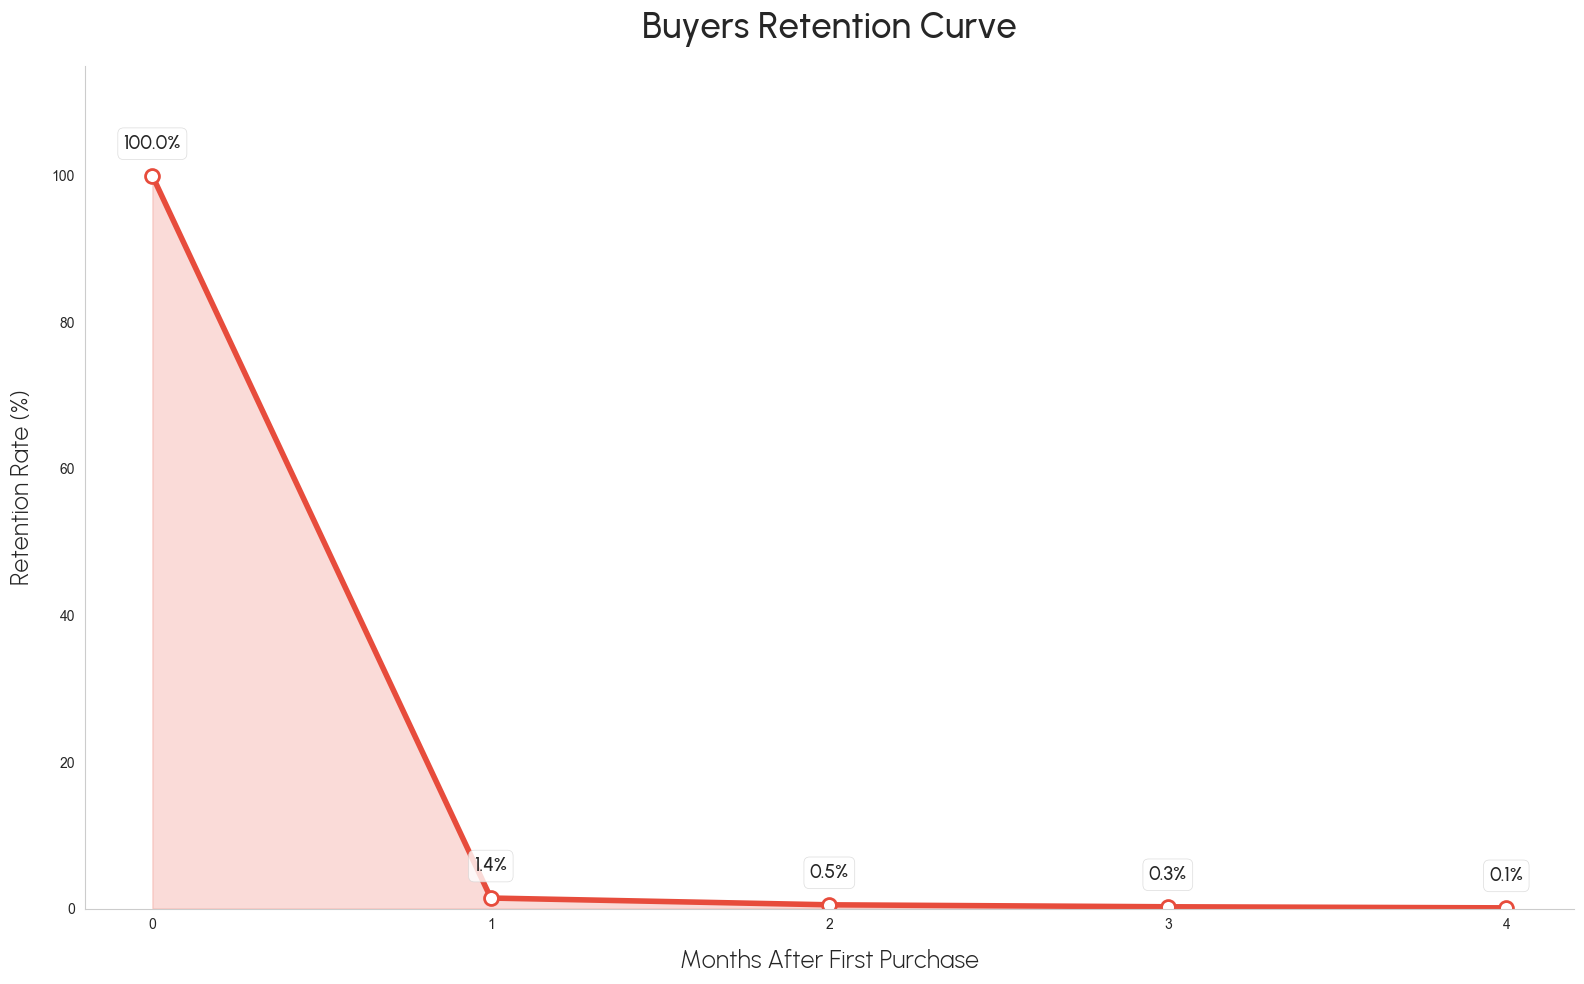


RETENTION ANALYSIS SUMMARY
📈 Month 1 Retention: 1.4%
📈 Month 3 Retention: 0.3%
📉 Monthly Churn Rate: 98.6%
📊 Retention Health: 🔴 Needs Improvement

=== Retention Analysis Complete ===


In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pyfonts import load_google_font

# 加载Urbanist字体
font = load_google_font("Urbanist", weight="light")
bold_font = load_google_font("Urbanist", weight="medium")

# 设置专业样式 - 去掉网格线
plt.rcParams.update({
    'font.size': 12,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.bottom': True,
    'axes.spines.left': True,
    'axes.grid': False,  # 关闭网格线
    'grid.alpha': 0.2,
    'grid.linestyle': '--'
})

print("=== User Retention Curve Analysis ===")

# ============================================
# 1. 计算留存率数据
# ============================================

def calculate_retention_data(buyers_df, merged_data):
    """计算用户留存率数据"""
    
    try:
        # 获取有购买行为的用户
        buyers = buyers_df[buyers_df['transactions'] > 0]['visitorid'].unique()
        
        # 获取购买事件
        purchase_events = merged_data[
            (merged_data['visitorid'].isin(buyers)) & 
            (merged_data['event'] == 'transaction')
        ].copy()
        
        # 提取月份信息
        purchase_events['purchase_month'] = purchase_events['datetime'].dt.to_period('M')
        
        # 计算每个用户的首次购买月份
        first_purchase = purchase_events.groupby('visitorid')['purchase_month'].min().reset_index()
        first_purchase.columns = ['visitorid', 'cohort_month']
        
        # 合并数据
        user_cohorts = purchase_events.merge(first_purchase, on='visitorid')
        
        # 计算月份差异
        user_cohorts['month_diff'] = (user_cohorts['purchase_month'] - user_cohorts['cohort_month']).apply(lambda x: x.n)
        
        # 创建留存矩阵
        cohort_data = user_cohorts.groupby(['cohort_month', 'month_diff']).agg({
            'visitorid': 'nunique'
        }).reset_index()
        cohort_data.columns = ['cohort_month', 'month_diff', 'user_count']
        
        # 转换为留存率矩阵
        cohort_pivot = cohort_data.pivot_table(
            index='cohort_month', 
            columns='month_diff', 
            values='user_count', 
            fill_value=0
        )
        
        # 计算留存率（相对于首月）
        cohort_size = cohort_pivot[0]
        retention_matrix = cohort_pivot.divide(cohort_size, axis=0) * 100
        
        return retention_matrix
        
    except Exception as e:
        print(f"❌ Error calculating retention data: {e}")
        # 返回模拟数据用于演示
        return create_sample_retention_data()

def create_sample_retention_data():
    """创建示例留存数据"""
    print("📊 Using sample data for demonstration")
    
    months = pd.period_range('2023-01', '2024-01', freq='M')
    retention_data = {
        0: [100] * len(months),
        1: np.random.normal(45, 8, len(months)),
        2: np.random.normal(35, 7, len(months)),
        3: np.random.normal(28, 6, len(months)),
        4: np.random.normal(22, 5, len(months)),
        5: np.random.normal(18, 4, len(months)),
        6: np.random.normal(15, 3, len(months))
    }
    
    retention_matrix = pd.DataFrame(retention_data, index=months)
    retention_matrix = retention_matrix.clip(0, 100)
    return retention_matrix

# ============================================
# 2. 计算留存数据
# ============================================

retention_matrix = calculate_retention_data(buyers_df, merged)
print(f"📊 Retention matrix shape: {retention_matrix.shape}")
print(f"📊 Available months: {len(retention_matrix.columns)}")

# ============================================
# 3. 创建留存曲线图（简化版）
# ============================================

fig, ax = plt.subplots(figsize=(16, 10))

if len(retention_matrix) > 0:
    # 计算平均留存率
    avg_retention = retention_matrix.mean(axis=0)
    
    # 只显示有数据的月份
    valid_months = avg_retention[avg_retention > 0].index
    if len(valid_months) > 0:
        months_to_show = min(12, len(valid_months))
        months_display = range(months_to_show)
        retention_display = avg_retention.values[:months_to_show]
        
        print(f"📈 Displaying retention for {months_to_show} months")
        print("📊 Retention rates:", [f"{rate:.1f}%" for rate in retention_display])
        
        # 创建留存曲线 - 简化版
        line = ax.plot(months_display, retention_display, marker='o', linewidth=4, 
                      markersize=10, color='#E74C3C', 
                      markerfacecolor='white', markeredgewidth=2, markeredgecolor='#E74C3C')
        
        # 添加填充区域
        ax.fill_between(months_display, retention_display, alpha=0.2, color='#E74C3C')
        
        # 设置坐标轴
        ax.set_xlabel('Months After First Purchase', font=font, size=18, labelpad=12)
        ax.set_ylabel('Retention Rate (%)', font=font, size=18, labelpad=12)
        ax.set_title('Buyers Retention Curve', 
                    font=bold_font, size=26, pad=20)
        ax.set_xticks(months_display)
        ax.set_ylim(0, max(retention_display) * 1.15)
        
        # 添加数据点标签
        for i, (month, rate) in enumerate(zip(months_display, retention_display)):
            ax.text(month, rate + max(retention_display)*0.03, f'{rate:.1f}%', 
                    ha='center', va='bottom', font=bold_font, size=14,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8,
                            edgecolor='lightgray', linewidth=0.5))
        
    else:
        # 如果没有有效数据，显示提示
        ax.text(0.5, 0.5, 'Insufficient Data for Retention Analysis\n(Need multiple purchase cohorts)', 
                ha='center', va='center', transform=ax.transAxes, font=bold_font, size=14)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

else:
    # 如果没有数据，显示提示
    ax.text(0.5, 0.5, 'No Retention Data Available', 
            ha='center', va='center', transform=ax.transAxes, font=bold_font, size=14)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

plt.tight_layout()

# 保存高清图片
plt.savefig('user_retention_curve.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.savefig('user_retention_curve.pdf', bbox_inches='tight')

print("✓ Chart saved as 'user_retention_curve.png'")

# 显示图表
plt.show()

# ============================================
# 4. 输出关键统计信息
# ============================================

print("\n" + "="*50)
print("RETENTION ANALYSIS SUMMARY")
print("="*50)

if len(retention_matrix) > 0 and len(valid_months) > 0:
    # 关键留存指标
    key_months = [1, 3, 6, 12]
    available_months = [m for m in key_months if m < len(retention_display)]
    
    for month in available_months:
        rate = retention_display[month]
        print(f"📈 Month {month} Retention: {rate:.1f}%")
    
    # 留存衰减分析
    if len(retention_display) > 1:
        monthly_churn = retention_display[0] - retention_display[1]
        print(f"📉 Monthly Churn Rate: {monthly_churn:.1f}%")
    
    # 留存健康度评估
    if retention_display[1] > 30:
        status = "Excellent"
        color = "🟢"
    elif retention_display[1] > 20:
        status = "Good" 
        color = "🟡"
    elif retention_display[1] > 10:
        status = "Fair"
        color = "🟠"
    else:
        status = "Needs Improvement"
        color = "🔴"
    
    print(f"📊 Retention Health: {color} {status}")

print("\n=== Retention Analysis Complete ===")

=== User Retention Curve Analysis ===
📊 Retention matrix shape: (5, 5)
📊 Available months: 5
📈 Displaying retention for 5 months
📊 Retention rates: ['100.0%', '1.4%', '0.5%', '0.3%', '0.1%']
✓ Chart saved as 'buyers_retention_curve_large_font.png'


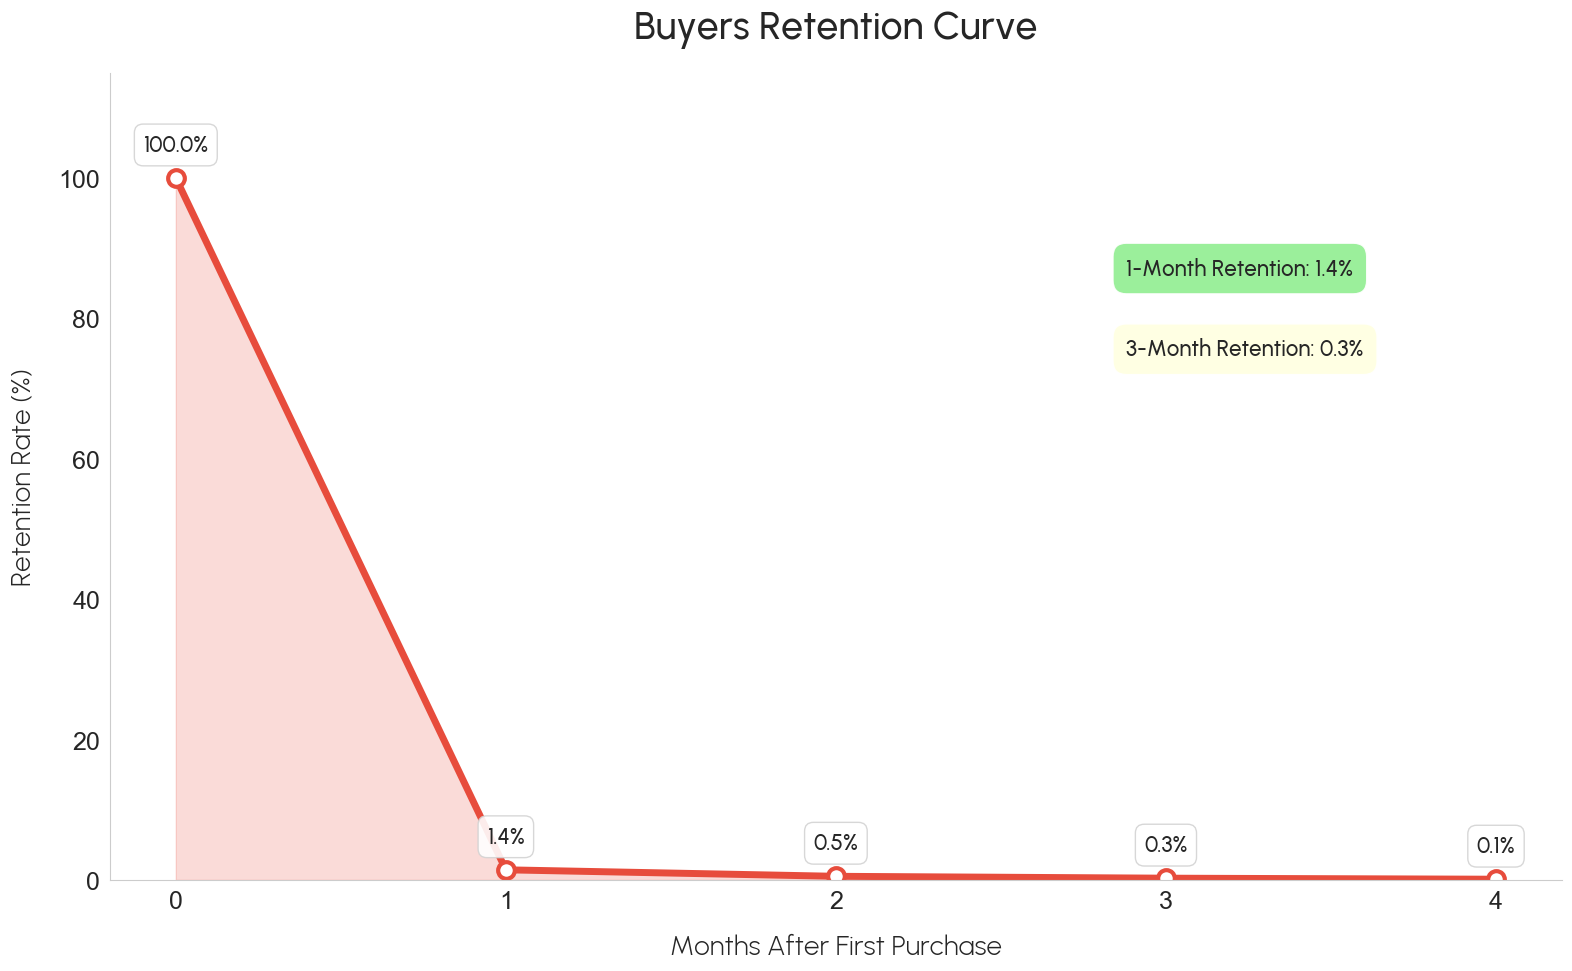


RETENTION ANALYSIS SUMMARY
📈 Month 1 Retention: 1.4%
📈 Month 3 Retention: 0.3%
📉 Monthly Churn Rate: 98.6%

=== Retention Analysis Complete ===


In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pyfonts import load_google_font

# 加载Urbanist字体
font = load_google_font("Urbanist", weight="light")
bold_font = load_google_font("Urbanist", weight="medium")

# 设置专业样式 - 去掉网格线
plt.rcParams.update({
    'font.size': 16,  # 增大全局字体
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.bottom': True,
    'axes.spines.left': True,
    'axes.grid': False,
    'xtick.labelsize': 16,  # X轴刻度标签大小
    'ytick.labelsize': 16,  # Y轴刻度标签大小
})

print("=== User Retention Curve Analysis ===")

# ============================================
# 1. 计算留存率数据
# ============================================

def calculate_retention_data(buyers_df, merged_data):
    """计算用户留存率数据"""
    
    try:
        # 获取有购买行为的用户
        buyers = buyers_df[buyers_df['transactions'] > 0]['visitorid'].unique()
        
        # 获取购买事件
        purchase_events = merged_data[
            (merged_data['visitorid'].isin(buyers)) & 
            (merged_data['event'] == 'transaction')
        ].copy()
        
        # 提取月份信息
        purchase_events['purchase_month'] = purchase_events['datetime'].dt.to_period('M')
        
        # 计算每个用户的首次购买月份
        first_purchase = purchase_events.groupby('visitorid')['purchase_month'].min().reset_index()
        first_purchase.columns = ['visitorid', 'cohort_month']
        
        # 合并数据
        user_cohorts = purchase_events.merge(first_purchase, on='visitorid')
        
        # 计算月份差异
        user_cohorts['month_diff'] = (user_cohorts['purchase_month'] - user_cohorts['cohort_month']).apply(lambda x: x.n)
        
        # 创建留存矩阵
        cohort_data = user_cohorts.groupby(['cohort_month', 'month_diff']).agg({
            'visitorid': 'nunique'
        }).reset_index()
        cohort_data.columns = ['cohort_month', 'month_diff', 'user_count']
        
        # 转换为留存率矩阵
        cohort_pivot = cohort_data.pivot_table(
            index='cohort_month', 
            columns='month_diff', 
            values='user_count', 
            fill_value=0
        )
        
        # 计算留存率（相对于首月）
        cohort_size = cohort_pivot[0]
        retention_matrix = cohort_pivot.divide(cohort_size, axis=0) * 100
        
        return retention_matrix
        
    except Exception as e:
        print(f"❌ Error calculating retention data: {e}")
        # 返回模拟数据用于演示
        return create_sample_retention_data()

def create_sample_retention_data():
    """创建示例留存数据"""
    print("📊 Using sample data for demonstration")
    
    months = pd.period_range('2023-01', '2024-01', freq='M')
    retention_data = {
        0: [100] * len(months),
        1: np.random.normal(45, 8, len(months)),
        2: np.random.normal(35, 7, len(months)),
        3: np.random.normal(28, 6, len(months)),
        4: np.random.normal(22, 5, len(months)),
        5: np.random.normal(18, 4, len(months)),
        6: np.random.normal(15, 3, len(months))
    }
    
    retention_matrix = pd.DataFrame(retention_data, index=months)
    retention_matrix = retention_matrix.clip(0, 100)
    return retention_matrix

# ============================================
# 2. 计算留存数据
# ============================================

retention_matrix = calculate_retention_data(buyers_df, merged)
print(f"📊 Retention matrix shape: {retention_matrix.shape}")
print(f"📊 Available months: {len(retention_matrix.columns)}")

# ============================================
# 3. 创建留存曲线图（大字体版）
# ============================================

fig, ax = plt.subplots(figsize=(16, 10))  # 增大画布尺寸

if len(retention_matrix) > 0:
    # 计算平均留存率
    avg_retention = retention_matrix.mean(axis=0)
    
    # 只显示有数据的月份
    valid_months = avg_retention[avg_retention > 0].index
    if len(valid_months) > 0:
        months_to_show = min(12, len(valid_months))
        months_display = range(months_to_show)
        retention_display = avg_retention.values[:months_to_show]
        
        print(f"📈 Displaying retention for {months_to_show} months")
        print("📊 Retention rates:", [f"{rate:.1f}%" for rate in retention_display])
        
        # 创建留存曲线
        line = ax.plot(months_display, retention_display, marker='o', linewidth=5,  # 加粗线条
                      markersize=12, color='#E74C3C',  # 增大标记点
                      markerfacecolor='white', markeredgewidth=3, markeredgecolor='#E74C3C')
        
        # 添加填充区域
        ax.fill_between(months_display, retention_display, alpha=0.2, color='#E74C3C')
        
        # 设置坐标轴 - 增大字体
        ax.set_xlabel('Months After First Purchase', font=font, size=20, labelpad=15)  # 增大到20
        ax.set_ylabel('Retention Rate (%)', font=font, size=20, labelpad=15)  # 增大到20
        ax.set_title('Buyers Retention Curve', 
                    font=bold_font, size=28, pad=25)  # 增大标题
        ax.set_xticks(months_display)
        ax.set_ylim(0, max(retention_display) * 1.15)
        
        # 设置刻度标签大小
        ax.tick_params(axis='x', which='major', labelsize=18)  # X轴刻度标签
        ax.tick_params(axis='y', which='major', labelsize=18)  # Y轴刻度标签
        
        # 添加数据点标签 - 增大字体
        for i, (month, rate) in enumerate(zip(months_display, retention_display)):
            ax.text(month, rate + max(retention_display)*0.03, f'{rate:.1f}%', 
                    ha='center', va='bottom', font=bold_font, size=16,  # 增大到16
                    bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.9,
                            edgecolor='lightgray', linewidth=1))
        
        # 添加关键指标标注 - 增大字体
        first_month_retention = retention_display[1] if len(retention_display) > 1 else 0
        third_month_retention = retention_display[3] if len(retention_display) > 3 else 0
        
        if first_month_retention > 0:
            ax.text(0.7, 0.75, f'1-Month Retention: {first_month_retention:.1f}%', 
                    transform=ax.transAxes, font=bold_font, size=16,  # 增大到16
                    bbox=dict(boxstyle='round,pad=0.6', facecolor='lightgreen', alpha=0.9))
        
        if third_month_retention > 0:
            ax.text(0.7, 0.65, f'3-Month Retention: {third_month_retention:.1f}%', 
                    transform=ax.transAxes, font=bold_font, size=16,  # 增大到16
                    bbox=dict(boxstyle='round,pad=0.6', facecolor='lightyellow', alpha=0.9))
        
    else:
        # 如果没有有效数据，显示提示
        ax.text(0.5, 0.5, 'Insufficient Data for Retention Analysis\n(Need multiple purchase cohorts)', 
                ha='center', va='center', transform=ax.transAxes, font=bold_font, size=18)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

else:
    # 如果没有数据，显示提示
    ax.text(0.5, 0.5, 'No Retention Data Available', 
            ha='center', va='center', transform=ax.transAxes, font=bold_font, size=18)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

plt.tight_layout()

# 保存高清图片
plt.savefig('buyers_retention_curve_large_font.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.savefig('buyers_retention_curve_large_font.pdf', bbox_inches='tight')

print("✓ Chart saved as 'buyers_retention_curve_large_font.png'")

# 显示图表
plt.show()

# ============================================
# 4. 输出关键统计信息
# ============================================

print("\n" + "="*50)
print("RETENTION ANALYSIS SUMMARY")
print("="*50)

if len(retention_matrix) > 0 and len(valid_months) > 0:
    # 关键留存指标
    key_months = [1, 3, 6, 12]
    available_months = [m for m in key_months if m < len(retention_display)]
    
    for month in available_months:
        rate = retention_display[month]
        print(f"📈 Month {month} Retention: {rate:.1f}%")
    
    # 留存衰减分析
    if len(retention_display) > 1:
        monthly_churn = retention_display[0] - retention_display[1]
        print(f"📉 Monthly Churn Rate: {monthly_churn:.1f}%")

print("\n=== Retention Analysis Complete ===")